# LAB 5
### Жерлыгин Максим
### М8О-408Б-18



In [62]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()  

In [63]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [64]:
data_dir = 'fruits'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

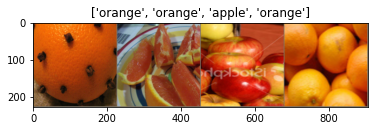

In [65]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Обучение 

In [66]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [67]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [68]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=8)

Epoch 0/7
----------
train Loss: 0.6047 Acc: 0.6867
test Loss: 0.1670 Acc: 0.9583

Epoch 1/7
----------
train Loss: 0.4975 Acc: 0.7933
test Loss: 0.1186 Acc: 0.9750

Epoch 2/7
----------
train Loss: 0.3283 Acc: 0.8567
test Loss: 0.3432 Acc: 0.8167

Epoch 3/7
----------
train Loss: 0.4689 Acc: 0.7967
test Loss: 0.0605 Acc: 0.9833

Epoch 4/7
----------
train Loss: 0.2762 Acc: 0.8767
test Loss: 0.0658 Acc: 0.9833

Epoch 5/7
----------
train Loss: 0.3837 Acc: 0.8333
test Loss: 0.2013 Acc: 0.9250

Epoch 6/7
----------
train Loss: 0.3815 Acc: 0.8467
test Loss: 0.0599 Acc: 0.9917

Epoch 7/7
----------
train Loss: 0.3647 Acc: 0.8500
test Loss: 0.0421 Acc: 0.9917

Training complete in 2m 33s
Best val Acc: 0.991667


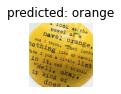

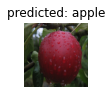

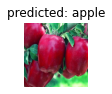

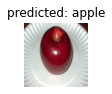

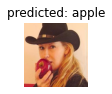

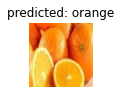

In [69]:
visualize_model(model_conv)
plt.ioff()
plt.show()


In [70]:
from PIL import Image

class MyDataset:
    def __init__(self, path, trans):
        self.data = []
        for i in os.listdir(path):
            self.data = self.data + [(trans(Image.open(path + '/' + i + '/' + k).convert('RGB')), 0)
                                     if i == 'apple'
                                     else (trans(Image.open(path + '/' + i + '/' + k).convert('RGB')), 1)
                                     for k in os.listdir(path + '/' + i)]

In [71]:
data_dir = 'fruits'
image_datasets = {x: MyDataset(os.path.join(data_dir, x), data_transforms[x]).data for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = ['apple', 'orange']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [72]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=8)

Epoch 0/7
----------
train Loss: 0.6104 Acc: 0.6867
test Loss: 0.1610 Acc: 0.9667

Epoch 1/7
----------
train Loss: 0.4063 Acc: 0.8200
test Loss: 0.3388 Acc: 0.8500

Epoch 2/7
----------
train Loss: 0.4718 Acc: 0.8033
test Loss: 0.4195 Acc: 0.8000

Epoch 3/7
----------
train Loss: 0.3782 Acc: 0.8367
test Loss: 0.0930 Acc: 0.9750

Epoch 4/7
----------
train Loss: 0.3370 Acc: 0.8567
test Loss: 0.0905 Acc: 0.9833

Epoch 5/7
----------
train Loss: 0.4047 Acc: 0.8067
test Loss: 0.1723 Acc: 0.9083

Epoch 6/7
----------
train Loss: 0.3897 Acc: 0.8333
test Loss: 0.1219 Acc: 0.9417

Epoch 7/7
----------
train Loss: 0.2382 Acc: 0.9033
test Loss: 0.1001 Acc: 0.9500

Training complete in 2m 19s
Best val Acc: 0.983333


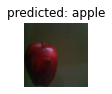

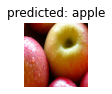

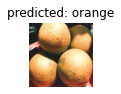

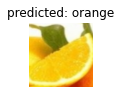

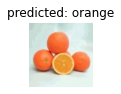

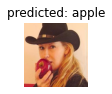

In [73]:
visualize_model(model_conv)
plt.ioff()
plt.show()

# MyConvNet

In [74]:
import torch.nn as nn
import torch.nn.functional as F

class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.c1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=2)
        self.c2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4)
        self.fc1 = nn.Linear(in_features=46656, out_features=2)
        
    def forward(self, x):
        x = F.max_pool2d(self.c1(x), 2)
        x = F.max_pool2d(self.c2(x), 4)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [75]:
model_ft = MyConvNet()
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=8)

Epoch 0/7
----------
train Loss: 5.3749 Acc: 0.6200
test Loss: 11.2282 Acc: 0.5000

Epoch 1/7
----------
train Loss: 11.8386 Acc: 0.7233
test Loss: 24.9811 Acc: 0.5833

Epoch 2/7
----------
train Loss: 248.7167 Acc: 0.6233
test Loss: 6342.9130 Acc: 0.5500

Epoch 3/7
----------
train Loss: nan Acc: 0.4833
test Loss: nan Acc: 0.5000

Epoch 4/7
----------
train Loss: nan Acc: 0.5000
test Loss: nan Acc: 0.5000

Epoch 5/7
----------
train Loss: nan Acc: 0.5000
test Loss: nan Acc: 0.5000

Epoch 6/7
----------
train Loss: nan Acc: 0.5000
test Loss: nan Acc: 0.5000

Epoch 7/7
----------
train Loss: nan Acc: 0.5000
test Loss: nan Acc: 0.5000

Training complete in 1m 57s
Best val Acc: 0.583333


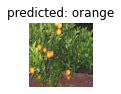

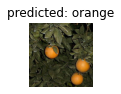

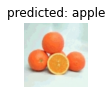

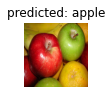

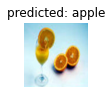

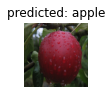

In [76]:
visualize_model(model_ft)
plt.ioff()
plt.show()